# Spatial transformer

We will revisit our CNN for the MNIST classification task. This time we will integrate a spatial transformer network as learned pre-processing component in our classification network.

**Objective:** Implement a spatial transformer network within a LeNet-like CNN for image classification.

In [1]:
# On Google Colab uncomment the following line to install PyTorch Lightning
# ! pip install lightning

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib
import matplotlib.pyplot as plt

from torch.utils.data import random_split, DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from pytorch_lightning import LightningModule, LightningDataModule, Trainer, seed_everything
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar
from torchmetrics.functional import accuracy

## Data

We use a [LightningDataModule](https://lightning.ai/docs/pytorch/stable/data/datamodule.html) for handling the MNIST dataset.

In [3]:
class MNISTDataModule(LightningDataModule):
    def __init__(self, data_dir: str = './data', batch_size: int = 32, num_workers: int = 4, transform = transforms.ToTensor()):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.transform = transform        

        self.test_set = MNIST(self.data_dir, train=False, transform=self.transform, download=True)
        dev_set = MNIST(self.data_dir, train=True, transform=self.transform, download=True)
        self.train_set, self.val_set = random_split(dev_set, [55000, 5000])

    def train_dataloader(self):
        return DataLoader(self.train_set, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers, persistent_workers=True)

    def val_dataloader(self):
        return DataLoader(self.val_set, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, persistent_workers=True)

    def test_dataloader(self):
        return DataLoader(self.test_set, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, persistent_workers=True)

## Model

We use a [LightningModule](https://lightning.ai/docs/pytorch/stable/common/lightning_module.html) for implementing the model and its training and testing steps.

**Task:** Implement the missing components of the STN and change the forward pass accordingly.

In [4]:
class ImageClassifier(LightningModule):
    def __init__(self, input_dim: tuple[int, int] = (28,28), output_dim: int = 10, learning_rate: float = 0.001):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.learning_rate = learning_rate
        self.transformed_images = []
        
        # LeNet
        self.conv = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
            )        
        self.fc = nn.Sequential(
            nn.Linear(16 * 4 * 4, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, self.output_dim)
            )
        
        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            # TASK: implement the STN localization component
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.regressor = nn.Sequential(
            # TASK: implement the STN regression component
            nn.Linear(10 * 3 * 3, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias of the last layer in regressor with identity transformation
        # TASK: uncomment once the STN is implemented
        self.regressor[-1].weight.data.zero_()
        self.regressor[-1].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    def stn(self, x):
        # TASK: uncomment once the STN is implemented
        xs = self.localization(x)
        xs = xs.view(x.size(0), -1)
        theta = self.regressor(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size(), align_corners=False)
        x = F.grid_sample(x, grid, align_corners=False)

        return x

    def forward(self, x):
        # pass input through STN
        xt = self.stn(x)
        # and transformed input through standard classification CNN
        x = self.conv(xt)
        x = x.view(x.size(0), -1)
        return self.fc(x), xt

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer
    
    def process_batch(self, batch):
        x, y = batch
        logits, xt = self(x)
        loss = F.cross_entropy(logits, y)
        probs = torch.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1)        
        acc = accuracy(preds, y, task='multiclass', num_classes=self.output_dim)
        return loss, acc, xt

    def training_step(self, batch, batch_idx):
        loss, acc, xt = self.process_batch(batch)
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', acc, prog_bar=True)
        if batch_idx == 0:
            grid = torchvision.utils.make_grid(batch[0][0:16, ...], nrow=4, normalize=True)
            self.logger.experiment.add_image('train_images', grid, self.global_step)

            grid = torchvision.utils.make_grid(xt[0:16, ...], nrow=4, normalize=True)
            self.logger.experiment.add_image('train_transformed_images', grid, self.global_step)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, acc, _ = self.process_batch(batch)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)

    def on_test_start(self):
        self.transformed_images = []

    def test_step(self, batch, batch_idx):
        loss, acc, xt = self.process_batch(batch)
        self.log('test_loss', loss)
        self.log('test_acc', acc)
        self.transformed_images.append(xt)

## Training

We use the PyTorch Lightning [Trainer](https://lightning.ai/docs/pytorch/stable/common/trainer.html) for training and testing.

In [5]:
seed_everything(42, workers=True)

data = MNISTDataModule(data_dir='./data', batch_size=32)

model = ImageClassifier(input_dim=(28,28), output_dim=10, learning_rate=0.001)

trainer = Trainer(
    max_epochs=10,
    accelerator='auto',
    devices=1,
    logger=TensorBoardLogger(save_dir='./lightning_logs/classification/', name='mnist-lenet-with-stn'),
    callbacks=[ModelCheckpoint(monitor='val_loss', mode='min'), TQDMProgressBar(refresh_rate=10)],
)
trainer.fit(model=model, datamodule=data)

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type       | Params | Mode 
----------------------------------------------------
0 | conv         | Sequential | 2.6 K  | train
1 | fc           | Sequential | 41.9 K | train
2 | localization | Sequential | 2.4 K  | train
3 | regressor    | Sequential | 3.1 K  | train
----------------------------------------------------
49.9 K    Trainable params
0         Non-trainable params
49.9 K    Total params
0.200     Total estimated mod

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


LeNet:
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
15        Modules in train mode
0         Modules in eval mode

With spatial transformer network: 49.9 K    Trainable params
0         Non-trainable params
49.9 K    Total params
0.200     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode

Vemos que es algo más pesado pero tampoco mucho. Aunque escalandolo si que puede haber diferencia

## Validation

Evaluate the trained model with the best checkpoint on the validation data and report the classification accuracy.

In [6]:
trainer.validate(model=model, datamodule=data, ckpt_path=trainer.checkpoint_callback.best_model_path)

Restoring states from the checkpoint path at ./lightning_logs/classification/mnist-lenet-with-stn/version_3/checkpoints/epoch=7-step=13752.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./lightning_logs/classification/mnist-lenet-with-stn/version_3/checkpoints/epoch=7-step=13752.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.9896000027656555
        val_loss            0.03559744358062744
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.03559744358062744, 'val_acc': 0.9896000027656555}]

## Testing

Evaluate the trained model with the best checkpoint on the test data and report the classification accuracy.

In [7]:
trainer.test(model=model, datamodule=data, ckpt_path=trainer.checkpoint_callback.best_model_path)
test_samples_transformed = model.transformed_images[0][0:16,...]

Restoring states from the checkpoint path at ./lightning_logs/classification/mnist-lenet-with-stn/version_3/checkpoints/epoch=7-step=13752.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./lightning_logs/classification/mnist-lenet-with-stn/version_3/checkpoints/epoch=7-step=13752.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9900000095367432
        test_loss           0.03367280215024948
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


## Testing on out-of-distribution data

Here we prepare an out-of-distribution test set where all digits are shifted by two pixels. We then test the trained model and report the classification accuracy.

**Task:** Compare the performance of the LeNet-like CNN with and without the STN component.

In [8]:
transform = transforms.Compose([
    transforms.CenterCrop((26,26)),
    transforms.Pad((0,0,2,2)),
    transforms.ToTensor()
])

data_ood = MNISTDataModule(data_dir='./data', batch_size=32, transform=transform)

trainer.test(model=model, datamodule=data_ood, ckpt_path=trainer.checkpoint_callback.best_model_path)
test_samples_ood_transformed = model.transformed_images[0][0:16,...]

Restoring states from the checkpoint path at ./lightning_logs/classification/mnist-lenet-with-stn/version_3/checkpoints/epoch=7-step=13752.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./lightning_logs/classification/mnist-lenet-with-stn/version_3/checkpoints/epoch=7-step=13752.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9811999797821045
        test_loss            0.061130590736866
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LeNet:
        test_acc            0.9692000150680542
        test_loss           0.10567992925643921

With spacial transformer network:
        test_acc            0.9811999797821045
        test_loss            0.061130590736866

Resultados buenisimos en ood, degrada mucho menos el resultado

## Visualisation

### Test data examples

Let's compare the original, in-distribution and the out-of-distribution test data.

Text(0.5, 1.0, 'difference')

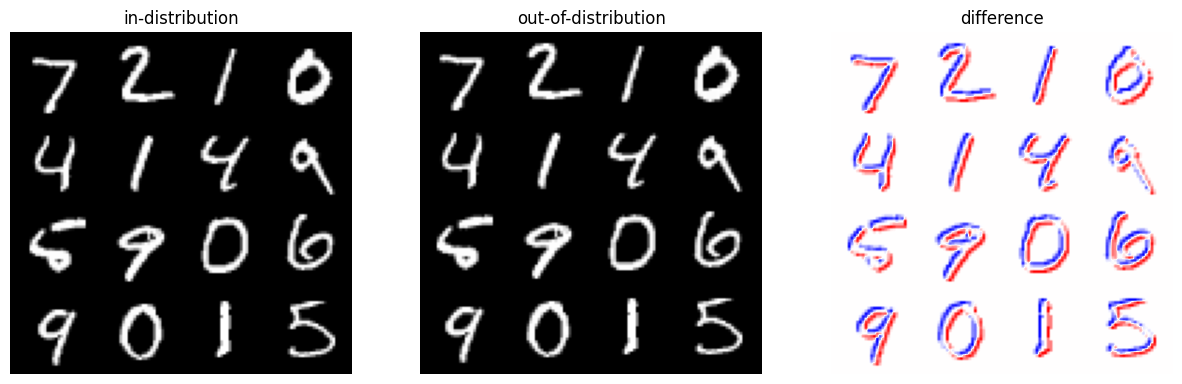

In [9]:
samples_iid = [data.test_set[i][0] for i in range(0,16)]
samples_ood = [data_ood.test_set[i][0] for i in range(0,16)]
grid_iid = torchvision.utils.make_grid(samples_iid, nrow=4, normalize=True).numpy()[0,...].squeeze()
grid_ood = torchvision.utils.make_grid(samples_ood, nrow=4, normalize=True).numpy()[0,...].squeeze()

f, ax = plt.subplots(1,3, figsize=(15, 15))

ax[0].imshow(grid_iid, cmap=matplotlib.cm.gray)
ax[0].axis('off')
ax[0].set_title('in-distribution')

ax[1].imshow(grid_ood, cmap=matplotlib.cm.gray)
ax[1].axis('off')
ax[1].set_title('out-of-distribution')

ax[2].imshow(grid_iid - grid_ood, cmap=matplotlib.cm.bwr)
ax[2].axis('off')
ax[2].set_title('difference')

Let's compare the original and the transformed test data when using a spatial transformer network within a classification CNN.

Text(0.5, 1.0, 'difference')

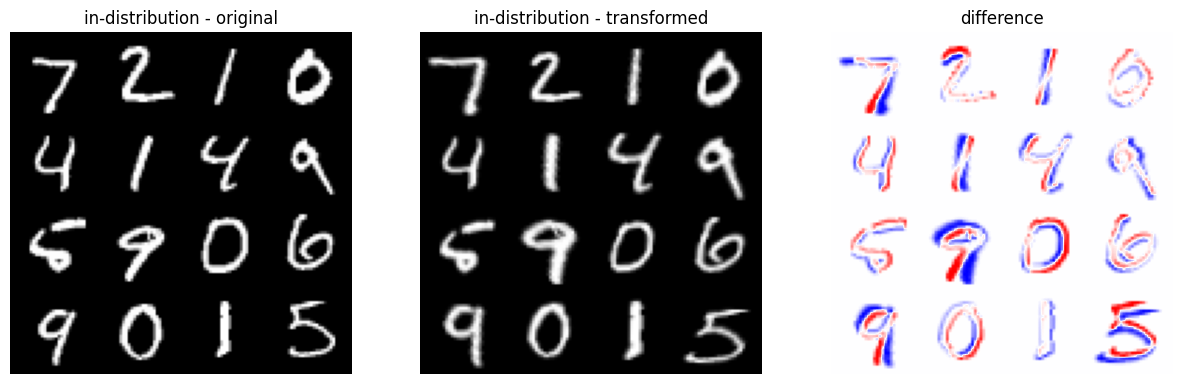

In [10]:
samples_iid = [data.test_set[i][0] for i in range(0,16)]
grid_original = torchvision.utils.make_grid(samples_iid, nrow=4, normalize=True).numpy()[0,...].squeeze()
grid_transformed = torchvision.utils.make_grid(test_samples_transformed.cpu(), nrow=4, normalize=True).numpy()[0,...].squeeze()

f, ax = plt.subplots(1,3, figsize=(15, 15))

ax[0].imshow(grid_original, cmap=matplotlib.cm.gray)
ax[0].axis('off')
ax[0].set_title('in-distribution - original')

ax[1].imshow(grid_transformed, cmap=matplotlib.cm.gray)
ax[1].axis('off')
ax[1].set_title('in-distribution - transformed')

ax[2].imshow(grid_original - grid_transformed, cmap=matplotlib.cm.bwr)
ax[2].axis('off')
ax[2].set_title('difference')

We see that the model has learned to transform the input images in a lot of situations

### Weights

Let's inspect the patterns that the single-layer network has learned for each digit class.

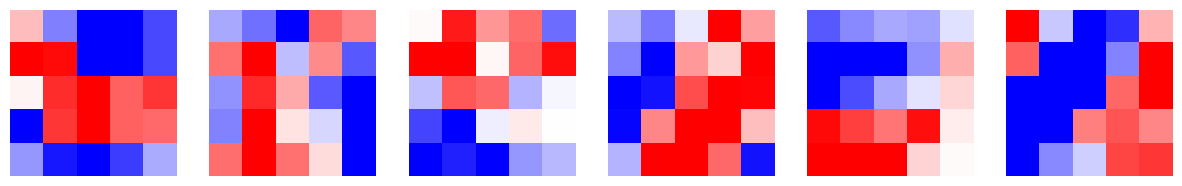

In [11]:
weights = model.conv[0].weight.detach().cpu().numpy()

f, ax = plt.subplots(1,6, figsize=(15, 15))

for i in range(0,6):
    vmax = np.max(np.abs(weights[i,:])) / 2
    ax[i].imshow(weights[i,:].reshape(5,5), cmap=matplotlib.cm.bwr, clim=(-vmax,vmax))
    ax[i].axis('off')

## Logging

In [12]:
%load_ext tensorboard
%tensorboard --logdir './lightning_logs/classification/'